In [ ]:
# 1. 导入库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [25]:
df = pd.read_csv('corporate_rating.csv')
print(df.info())
print(df['Rating'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Rating                              2029 non-null   object 
 1   Name                                2029 non-null   object 
 2   Symbol                              2029 non-null   object 
 3   Rating Agency Name                  2029 non-null   object 
 4   Date                                2029 non-null   object 
 5   Sector                              2029 non-null   object 
 6   currentRatio                        2029 non-null   float64
 7   quickRatio                          2029 non-null   float64
 8   cashRatio                           2029 non-null   float64
 9   daysOfSalesOutstanding              2029 non-null   float64
 10  netProfitMargin                     2029 non-null   float64
 11  pretaxProfitMargin                  2029 no

In [24]:
non_feature_cols = ['Rating','Name','Symbol','Rating Agency Name','Date','Sector']
feature_cols = [col for col in df.columns if col not in non_feature_cols and df[col].dtype in [np.float64, np.int64]]
counts = df['Rating'].value_counts()
valid_classes = counts[counts >= 5].index  # 保留至少5条样本的类别
df_filtered = df[df['Rating'].isin(valid_classes)]
X = df[feature_cols]
y = df['Rating']
print("保留的类别及样本数：\n", y.value_counts())

保留的类别及样本数：
 Rating
BBB    671
BB     490
A      398
B      302
AA      89
CCC     64
AAA      7
CC       5
C        2
D        1
Name: count, dtype: int64


In [26]:
# 3. 映射评级为三大类
rating_map = {
    'AAA': 'Investment', 'AA': 'Investment', 'A': 'Investment',
    'BBB': 'Medium', 'BB': 'Medium',
    'B': 'Speculative', 'CCC': 'Speculative', 'CC': 'Speculative',
    'C': 'Speculative', 'D': 'Speculative'
}

df['Rating_Class'] = df['Rating'].map(rating_map)

print(df['Rating_Class'].value_counts())


Rating_Class
Medium         1161
Investment      494
Speculative     374
Name: count, dtype: int64


In [27]:
# 4. 特征选择
feature_cols = [
    'currentRatio', 'quickRatio', 'cashRatio',
    'daysOfSalesOutstanding', 'netProfitMargin', 'pretaxProfitMargin',
    'grossProfitMargin', 'operatingProfitMargin',
    'returnOnAssets', 'returnOnCapitalEmployed', 'returnOnEquity',
    'assetTurnover', 'fixedAssetTurnover', 'debtEquityRatio',
    'operatingCashFlowSalesRatio', 'payablesTurnover'
]

X = df[feature_cols]
y = df['Rating_Class']


In [28]:
# 5. 数据预处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 降维到解释 95% 方差（可选）
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("原始维度:", X_scaled.shape[1], "-> PCA降维后:", X_pca.shape[1])


原始维度: 16 -> PCA降维后: 8


In [29]:
# 6. 训练集/测试集划分
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print("训练集大小:", X_train.shape, "测试集大小:", X_test.shape)


训练集大小: (1623, 8) 测试集大小: (406, 8)


In [ ]:
# 7. 调参：KNN 网格搜索
param_grid = {
    'n_neighbors': list(range(3, 21, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("最佳参数:", grid.best_params_)
print("训练集最佳准确率:", grid.best_score_)


最佳参数: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
训练集最佳准确率: 0.6013542260208927


测试集结果:
              precision    recall  f1-score   support

  Investment       0.47      0.36      0.41        99
      Medium       0.64      0.83      0.72       232
 Speculative       0.48      0.19      0.27        75

    accuracy                           0.60       406
   macro avg       0.53      0.46      0.47       406
weighted avg       0.57      0.60      0.56       406



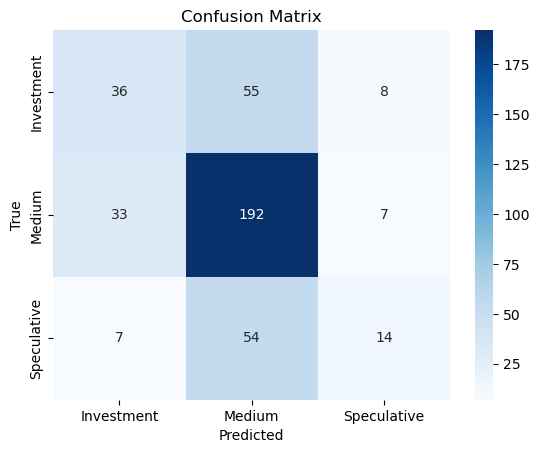

In [31]:
# 8. 模型评估
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

print("测试集结果:")
print(classification_report(y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred, labels=['Investment', 'Medium', 'Speculative'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Investment', 'Medium', 'Speculative'],
            yticklabels=['Investment', 'Medium', 'Speculative'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


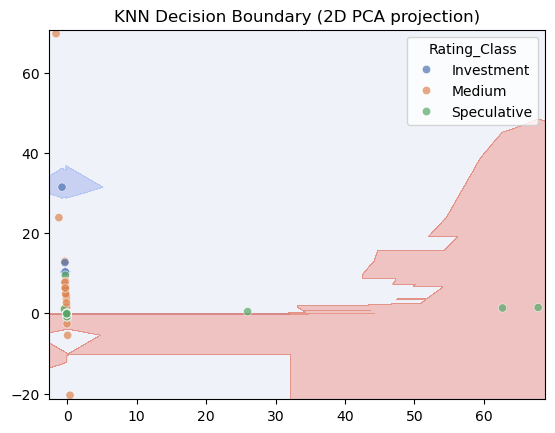

In [32]:
# 9. 降到2D后可视化决策边界（仅作展示）
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_scaled)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_2d, y, test_size=0.2, random_state=42, stratify=y
)

knn2 = KNeighborsClassifier(**grid.best_params_)
knn2.fit(X_train2, y_train2)

# 绘制决策边界
h = .05
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = pd.Series(Z).map({'Investment':0,'Medium':1,'Speculative':2}).values.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y, alpha=0.7, palette="deep")
plt.title("KNN Decision Boundary (2D PCA projection)")
plt.show()
